In [29]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from numpy.random import rand
import collections
import datetime
import dateutil.parser
import pandas as pd

# plt.style.use('science')
plt.style.use(['science','no-latex','ieee'])

In [2]:
# params
# actions = 6
# actionReward = [3, 13, -1, -20, 2, 0]
# regularActionDistribution = [0.561, 0.257, 0.156, 0.015, 0.02]
# crisisActionDistribution = [0.479, 0.106, 0.321, 0.086, 0]
# actionsToCurateLBCR = 70
# interactionFrequencyPerBlock = 0.07875
# interactionFrequencyPerBlock = 1.2675

aaveTxs = pd.read_csv("aave.csv")
aaveTxs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

synthetixTxs = pd.read_csv("synthetix.csv")
synthetixTxs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

compoundTxs = pd.read_csv("compound.csv")
compoundTxs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

makerTxs = pd.read_csv("maker.csv")
makerTxs.sort_values(by=['dateyear', 'datemonth', 'dateday', 'datehour', 'dateminute'])

ethDaiPriceCSV = pd.read_csv("ethdaiprice.csv")

In [230]:
class LbcrSimulator:
    
    def __init__(
        self,
        txs, 
        userCount, 
        rewards,
        ethDaiPriceFeed,
        layerCount, 
        layerScores, 
        layerDiscounts,
        layerCurationInterval,
        interactionFrequencyProbabilities,
        useAsymmetricLayerPromotion = True,
        startIndex = 0,
        endIndex = -1,
        movingAverageWindow = 15,
        csvMinutesInInterval = 30,
        priceFeedScaleFactor = 10
    ):
        self.txs = txs
        self.userCount = userCount
        self.rewards = rewards
        self.ethDaiPriceFeed = ethDaiPriceFeed
        self.layerCount = layerCount
        self.layerScores = layerScores
        self.layerDiscounts = layerDiscounts
        self.layerCurationInterval = layerCurationInterval
        self.interactionFrequencyProbabilities = interactionFrequencyProbabilities
        self.useAsymmetricLayerPromotion = useAsymmetricLayerPromotion
        self.startIndex = startIndex
        if endIndex > 0:
            self.endIndex = endIndex
        else:
            self.endIndex = len(self.txs)
        self.movingAverageWindow = movingAverageWindow
        self.csvMinutesInInterval = csvMinutesInInterval
        self.priceFeedScaleFactor = priceFeedScaleFactor
        
        self.userScore = [0] * userCount
        self.userLayers = [0] * userCount

        self.userLayerPositionsOverTime = [[] for _ in range(userCount)]
        self.userLayerDiscountsOverTime = [[] for _ in range(userCount)]
        self.userLayerDiscountsPerPercentileOverTime = [[] for _ in range(len(interactionFrequencyProbabilities))]
        self.userScoreOverTime = [[] for _ in range(userCount)]
        
        self.curationDates = []
        self.pricesAtCuration = []
        self.roundActionCounts = []
        self.avgScores = []
        self.avgLayers = []
        self.avgDiscountPerInterval = []
        self.currentRoundActionCount = 0
        self.ethereumBlocksPerMinute = 4
        self.blocksPerCsvInterval = self.csvMinutesInInterval * self.ethereumBlocksPerMinute
    
    def movingAverage(self, v):
        windowSize = self.movingAverageWindow
        length = min(len(v), windowSize)
        if not length:
            # if no actions were simulated yet, assume an average of 3 txs per interval
            return 3
        return sum(v[:-length]) / length

    def curate(self, currentTx):
        for user in range(self.userCount):
            newLayer = 0
            self.userScoreOverTime[user].append(self.userScore[user])
            
#             if(user % len(self.interactionFrequencyProbabilities) == 0):
#                 print(self.userScore[user])

            while newLayer + 1 < self.layerCount and self.userScore[user] >= self.layerScores[newLayer + 1]:
                newLayer += 1
                
            if self.useAsymmetricLayerPromotion:
                if newLayer < self.userLayers[user]:
                     self.userLayers[user] = newLayer
                elif newLayer > self.userLayers[user]:
                     self.userLayers[user] += 1
            else:
                self.userLayers[user] = newLayer

            self.userScore[user] = 0
            self.userLayerPositionsOverTime[user].append(self.userLayers[user])
            newLayerDiscount = self.layerDiscounts[self.userLayers[user]]
#             self.userLayerDiscountsOverTime[user].append(newLayerDiscount)
            
            if not self.userLayerDiscountsOverTime[user]:
                self.userLayerDiscountsOverTime[user].append(newLayerDiscount)
            else:
                self.userLayerDiscountsOverTime[user].append(newLayerDiscount * 0.5 + 0.5 * self.userLayerDiscountsOverTime[user][-1])


#             if(user % len(self.interactionFrequencyProbabilities) == 0):
#                 print(self.userScore[user])
        dateFormat = [
            currentTx.dateyear,
            currentTx.datemonth,
            currentTx.dateday,
            currentTx.datehour,
            str(int(currentTx.dateminute) * self.csvMinutesInInterval),
            "00"
        ]
        curationDate = datetime.datetime(*map(int, dateFormat))
        self.curationDates.append(curationDate)
        self.roundActionCounts.append(self.currentRoundActionCount)
        self.currentRoundActionCount = 0
        

    def drawActionFromDistribution(self, actionCounts, totalCount):
        randomDraw = rand()
        sum = 0
        for (key, actionCount) in actionCounts.items():
            sum += actionCount / totalCount
            if randomDraw < sum:
                return key
        return None

    def avg(self, v):
        if not v:
            return None
        return sum(v)/len(v)

    def countActionsAtOnChainTime(self, index):
        counts = collections.defaultdict(int)
        totalCount = 0
        tx = self.txs.iloc[index]
        counts[tx.f0_] = tx.f1_
        totalCount += tx.f1_
        while index + 1 < len(self.txs) and tx.dateyear == self.txs.iloc[index + 1].dateyear and \
            tx.datemonth == self.txs.iloc[index + 1].datemonth and \
            tx.dateday == self.txs.iloc[index + 1].dateday and \
            tx.datehour == self.txs.iloc[index + 1].datehour and \
            tx.dateminute == self.txs.iloc[index + 1].dateminute:

            tx = self.txs.iloc[index]
            counts[tx.f0_] += tx.f1_
            totalCount += tx.f1_
            index += 1
        
        return (counts, totalCount)
    
    def hasUserActedInCurrentBlock(self, totalOnChainActionCount):
        return rand() <= (1/totalOnChainActionCount)*(1/self.userCount)
    
    def getUsersInPercentile(self, percentile):
        percentileCount = len(self.interactionFrequencyProbabilities)
        minimumUsersInEachPercentile = int(self.userCount / percentileCount)
        if percentile < self.userCount % percentileCount:
            return minimumUsersInEachPercentile + 1
        return minimumUsersInEachPercentile
    
    def doesUserPerformCurrentAction(self, user):
        percentileCount = len(self.interactionFrequencyProbabilities)
        percentile = user % percentileCount
        usersInPercentile = self.getUsersInPercentile(percentile)
        probabilityThatUserInPercentileTransacts = self.interactionFrequencyProbabilities[percentile]
        return rand() <= probabilityThatUserInPercentileTransacts / usersInPercentile
    
    def idealCurationNumberUpToIndex(self, index):
        return (index * self.blocksPerCsvInterval) / self.layerCurationInterval
    
    def currentRoundScaleFactorBasedOnVolumes(self):
        return self.movingAverage(self.roundActionCounts) / self.currentRoundActionCount
    
    def simulate(self):
        priceFeedIndex = 0
        i = self.startIndex - 1
        while i + 1 < self.endIndex:
            i += 1
            onChainActionCountDict, totalOnChainActionCount = self.countActionsAtOnChainTime(i)

            for j in range(totalOnChainActionCount):
                for user in range(self.userCount):
#                     if self.hasUserActedInCurrentBlock(totalOnChainActionCount):
                    if self.doesUserPerformCurrentAction(user):
                        action = self.drawActionFromDistribution(onChainActionCountDict, totalOnChainActionCount)
                        self.currentRoundActionCount += 1
                        if action in self.rewards:
                            self.userScore[user] += self.rewards[action]
                        if self.idealCurationNumberUpToIndex(i) >= len(self.curationDates) * self.currentRoundScaleFactorBasedOnVolumes():
                            self.curate(self.txs.iloc[i])
                            while priceFeedIndex < len(self.ethDaiPriceFeed) \
                                and dateutil.parser.parse(self.ethDaiPriceFeed.iloc[priceFeedIndex].time, ignoretz=True) < self.curationDates[-1]:
                                priceFeedIndex += 1
                            self.pricesAtCuration.append(self.ethDaiPriceFeed.iloc[priceFeedIndex].close / self.priceFeedScaleFactor)

    def computeSimulationStatistics(self):
        for i in range(len(self.userLayerPositionsOverTime)):
            self.avgLayers.append(self.avg(self.userLayerPositionsOverTime[i]))
            self.avgScores.append(self.avg(self.userScoreOverTime[i]))

        for i in range(len(self.userLayerDiscountsOverTime[0])):
            discounts = []
            percentileCount = len(self.interactionFrequencyProbabilities)
            percentileDiscounts = [[] for _ in range(percentileCount)]
            
            for user in range(self.userCount):
                discounts.append(self.userLayerDiscountsOverTime[user][i])
                userPercentile = user % percentileCount
                percentileDiscounts[userPercentile].append(self.userLayerDiscountsOverTime[user][i])
                        
            for percentile in range(percentileCount):        
                self.userLayerDiscountsPerPercentileOverTime[percentile].append(self.avg(percentileDiscounts[percentile]))
            self.avgDiscountPerInterval.append(self.avg(discounts))
            
        print(self.avg(self.avgScores))
        print(self.avg(self.avgLayers))
#         print(self.avg(self.avgDiscountPerInterval[25:]))
#         print(len(self.avgDiscountPerInterval))

    def displaySimulationResults(self):
        def forward(x):
            return x * self.priceFeedScaleFactor

        def inverse(x):
            return x / self.priceFeedScaleFactor
        
        def scaleDiscount(x):
            # 100 stands for percentages
            return x * 100

        plt.style.reload_library()
        plt.figure()
        fig, ax = plt.subplots()
        scaledAvgDiscountPerInterval = [scaleDiscount(x) for x in self.userLayerDiscountsPerPercentileOverTime[0]]
        ax.plot(self.curationDates, scaledAvgDiscountPerInterval, label='Average Collateral Reduction')
        ax.plot(self.curationDates, self.pricesAtCuration, label='ETH/DAI Price')
        plt.gcf().autofmt_xdate()
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Collateral Reduction (%)')
        secax = ax.secondary_yaxis('right', functions=(forward, inverse))
        secax.set_ylabel('ETH/DAI Price')
        legend = plt.legend(loc='best', fontsize='xx-small')
        plt.show()
    
# crisis:
# 0.01611379310344828

# regular:
# 0.07072195121951218

In [77]:
def displaySimulationResults(time, prices, discountArray1, label1, discountArray2, label2, priceFeedScaleFactor):
    def forward(x):
        return x * priceFeedScaleFactor

    def inverse(x):
        return x / priceFeedScaleFactor

    def scaleDiscount(x):
        # 100 stands for percentages
        return x * 100

    with plt.style.context(['science', 'grid', 'no-latex']):
        plt.style.reload_library()
        plt.figure()
        fig, ax = plt.subplots()

        scaledDiscountArray1 = [scaleDiscount(x) for x in discountArray1]
        scaledDiscountArray2 = [scaleDiscount(x) for x in discountArray2]

        ax.plot(time, prices, label='ETH/DAI Price')
        ax.plot(time, scaledDiscountArray1, label=label1)
        ax.plot(time, scaledDiscountArray2, label=label2)
        plt.gcf().autofmt_xdate()
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Collateral Reduction (%)')
        secax = ax.secondary_yaxis('right', functions=(forward, inverse))
        secax.set_ylabel('ETH/DAI Price')
        legend = plt.legend(loc='best', fontsize='xx-small')
        plt.show()

In [315]:
def displayNSimulationResults(timeArray, prices, priceFeedScaleFactor, discountsArray, labelArray, discountScale = 100, ylabel = 'Collateral Reduction (%)'):
    def forward(x):
        return x * priceFeedScaleFactor

    def inverse(x):
        return x / priceFeedScaleFactor

    def scaleDiscount(x):
        # 100 stands for percentages
        return x * discountScale

    with plt.style.context(['science', 'grid', 'no-latex']):
        plt.style.reload_library()
        plt.figure()
        fig, ax = plt.subplots()

        scaledDiscountsArray = []
        for discounts in discountsArray:
            scaledDiscount = [scaleDiscount(x) for x in discounts]
            scaledDiscountsArray.append(scaledDiscount)
            
        ax.plot(timeArray[0], prices, label='ETH/DAI Price')
        for i in range(len(scaledDiscountsArray)):
            ax.plot(timeArray[i], scaledDiscountsArray[i], label=labelArray[i])
        
        plt.gcf().autofmt_xdate()
        ax.set_xlabel('Time (days)')
        ax.set_ylabel(ylabel)
        secax = ax.secondary_yaxis('right', functions=(forward, inverse))
        secax.set_ylabel('ETH/DAI Price')
        legend = plt.legend(loc='best', fontsize='xx-small')
        plt.show()

In [228]:
aaveUserCount = 50

# aaveRewards = {
#     "0xd2d0e066": 1,
#     "0xc858f5f9": 4,
#     "0x5ceae9c4": -4,
#     "0x00a718a9": -10,
#     "0x5cffe9de": 2
# }

# layerCount = 10
# layerScores = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
# layerDiscounts = [0, 0.01, 0.02, 0.03, 0.04, 0.051, 0.062, 0.074, 0.086, 0.098, 0.1]
interactionFrequencyProbabilities = [0.899446027, 0.077726537, 0.011287632, 0.00503731, 0.002818637, 0.001695928, 0.001048091, 0.000620348, 0.000319492]


# deposit, borrow, repay, liquidate, flashLoan, others
# 0xd2d0e066, 0xc858f5f9, 0x5ceae9c4, 0x00a718a9, 0x5cffe9de, ...
aaveRewards = {
    "0xd2d0e066": 3,
    "0xc858f5f9": 25,
    "0x5ceae9c4": -15,
    "0x00a718a9": -20,
    "0x5cffe9de": 3
}
layerCurationInterval = 7200


layerCount = 5
layerScores = [0, 12, 22, 31, 40]
layerDiscounts = [0, 0.03, 0.06, 0.09, 0.1]
# interactionFrequencyProbabilities = [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111]

aaveSimulator = LbcrSimulator(aaveTxs, aaveUserCount, aaveRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities)
# aaveSimulator1 = LbcrSimulator(aaveTxs, aaveUserCount, aaveRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities, startIndex = 5000, endIndex = 7200)
aaveSimulator.simulate()
aaveSimulator.computeSimulationStatistics()


# aaveSimulator2 = LbcrSimulator(aaveTxs, aaveUserCount, aaveRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities, movingAverageWindow = 15)
# aaveSimulator2.simulate()
# aaveSimulator2.computeSimulationStatistics()


# aaveSimulator3 = LbcrSimulator(aaveTxs, aaveUserCount, aaveRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities, movingAverageWindow = 30)
# aaveSimulator3.simulate()
# aaveSimulator3.computeSimulationStatistics()

# aaveRewards = {
#     "0xd2d0e066": -1,
#     "0xc858f5f9": -1,
#     "0x5ceae9c4": -1,
#     "0x00a718a9": -4,
#     "0x5cffe9de": -1
# }
# layerCurationInterval = 4900
# aaveSimulator4 = LbcrSimulator(aaveTxs, aaveUserCount, aaveRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities)
# aaveSimulator4.simulate()
# aaveSimulator4.computeSimulationStatistics()

# aaveRewards = {
#     "0xd2d0e066": -1,
#     "0xc858f5f9": -1,
#     "0x5ceae9c4": -1,
#     "0x00a718a9": -1,
#     "0x5cffe9de": -4
# }
# layerCurationInterval = 5900
# aaveSimulator5 = LbcrSimulator(aaveTxs, aaveUserCount, aaveRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities)
# aaveSimulator5.simulate()
# aaveSimulator5.computeSimulationStatistics()
# aaveSimulator.displaySimulationResults()



36.899115044247786
0.490442477876106


<Figure size 2100x1575 with 0 Axes>

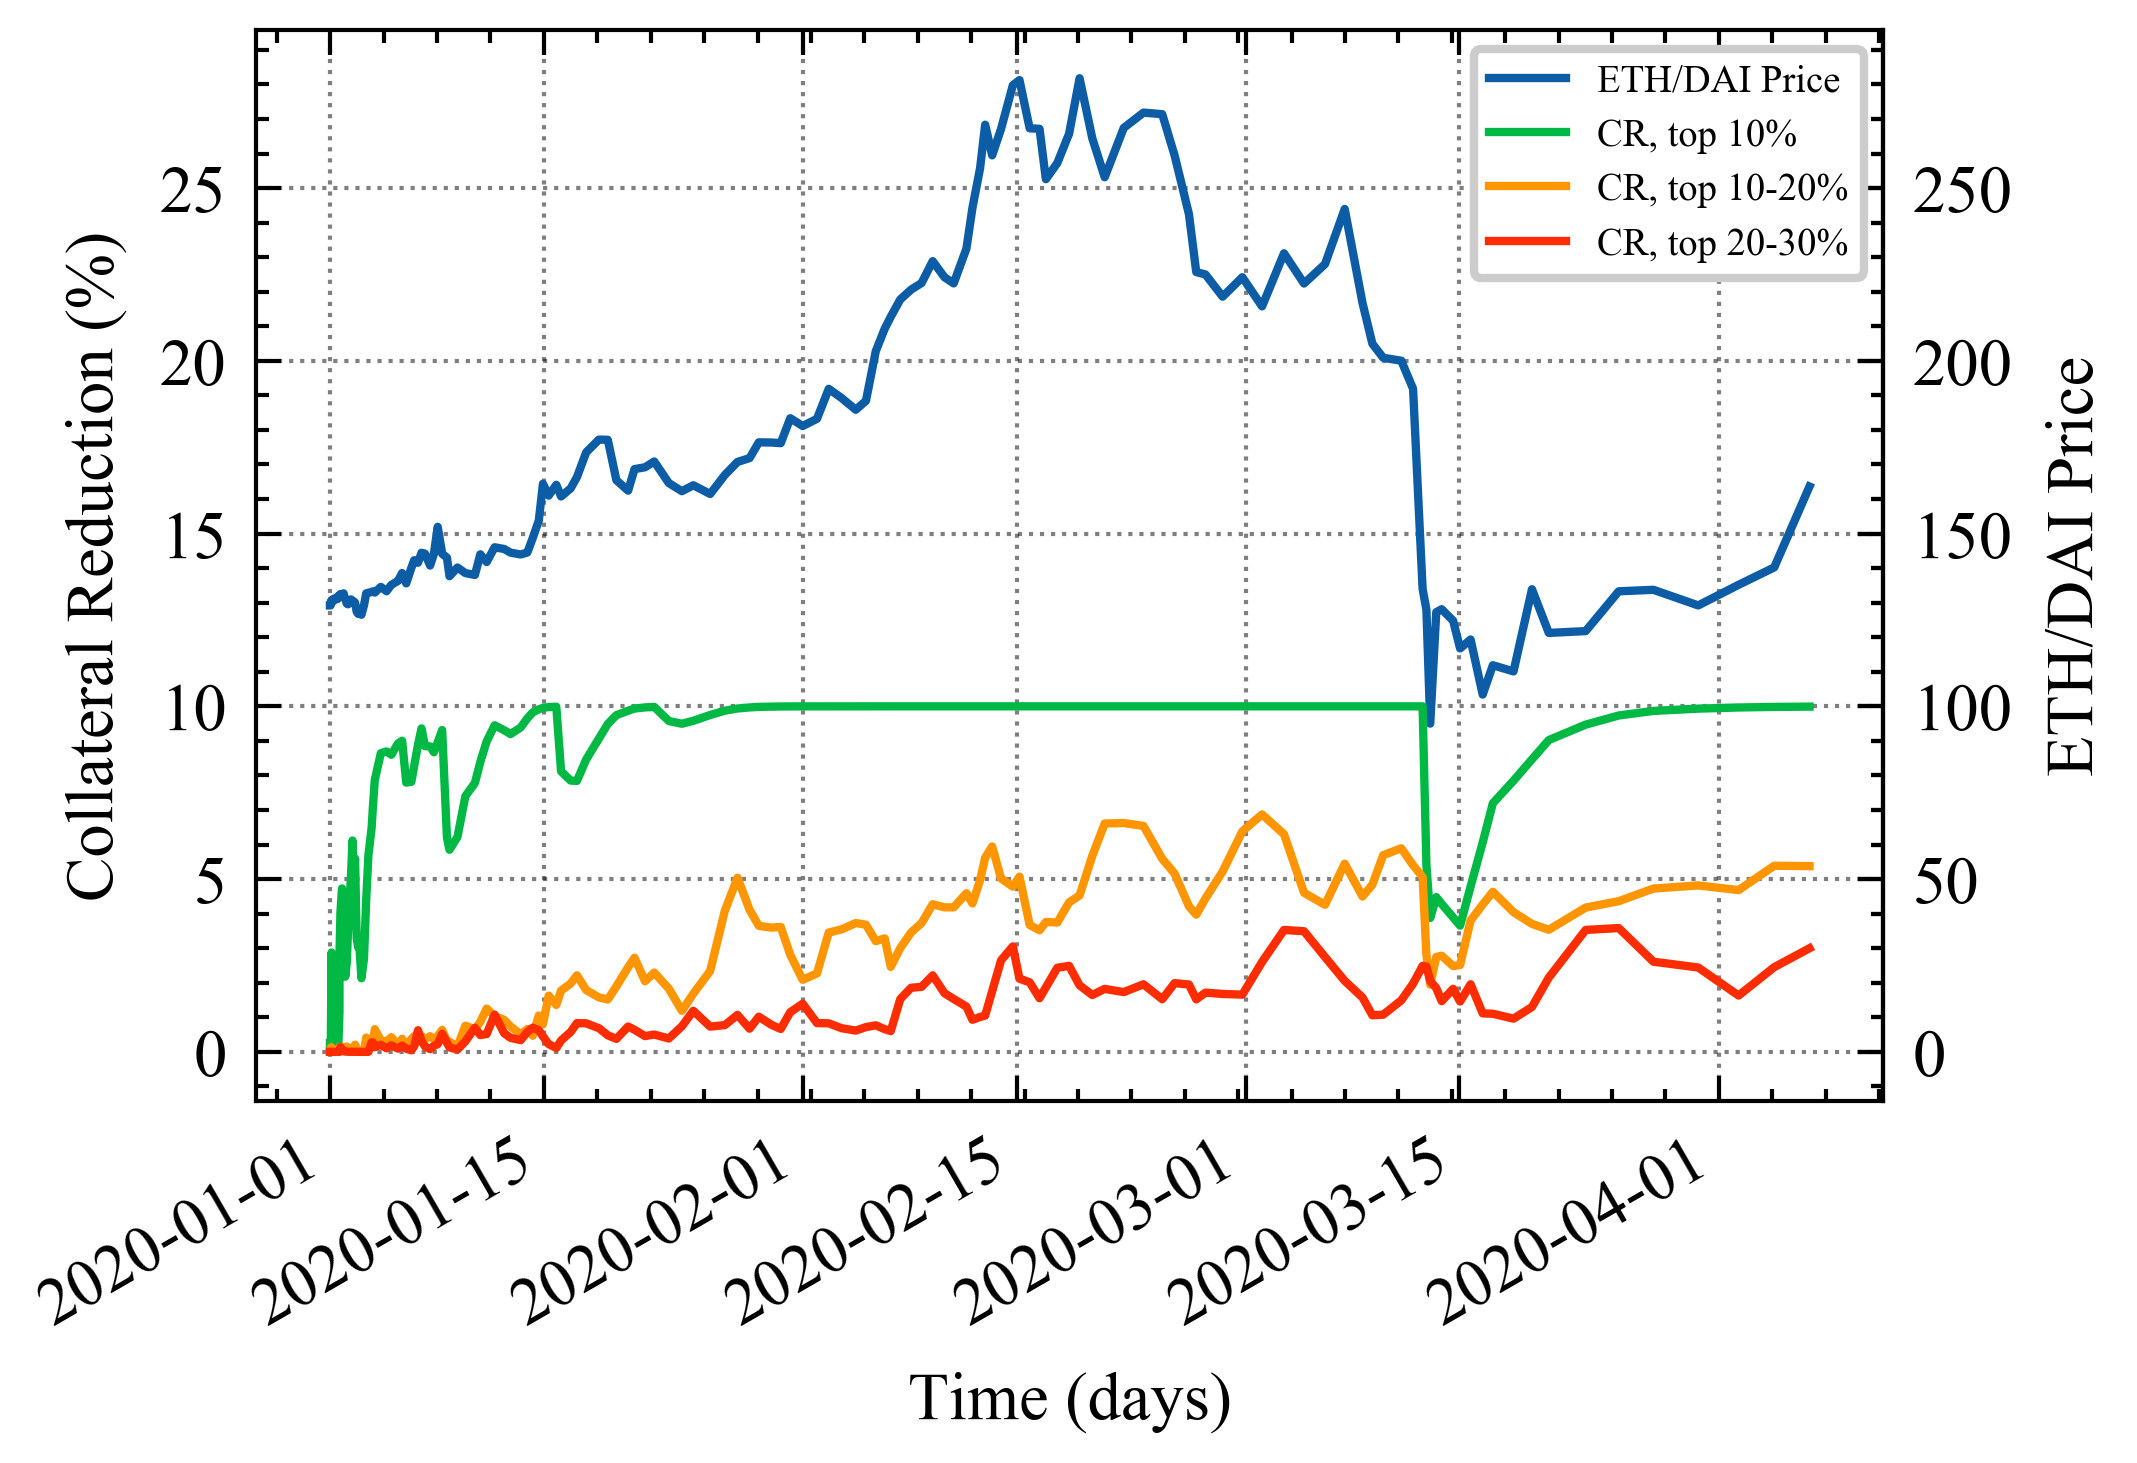

In [258]:

curationDatesArray = [
    compoundSimulator.curationDates,
    compoundSimulator.curationDates,
    compoundSimulator.curationDates,
#     aaveSimulator4.curationDates,
#     aaveSimulator5.curationDates
]

discountsArray = [
    compoundSimulator.userLayerDiscountsPerPercentileOverTime[0],
    compoundSimulator.userLayerDiscountsPerPercentileOverTime[1],
    compoundSimulator.userLayerDiscountsPerPercentileOverTime[2],
#     aaveSimulator3.userLayerDiscountsPerPercentileOverTime[0],
#     aaveSimulator4.userLayerDiscountsPerPercentileOverTime[0],
#     aaveSimulator5.userLayerDiscountsPerPercentileOverTime[0],
#     aaveSimulator1.userLayerDiscountsPerPercentileOverTime[1],
#     aaveSimulator2.avgDiscountPerInterval,
#     aaveSimulator3.avgDiscountPerInterval,
#     aaveSimulator4.avgDiscountPerInterval,
#     aaveSimulator5.avgDiscountPerInterval
]

labelArray = [
    "CR, top 10%",
    "CR, top 10-20%",
    "CR, top 20-30%",
]

displayNSimulationResults(
    curationDatesArray,
    compoundSimulator.pricesAtCuration,
    compoundSimulator.priceFeedScaleFactor,
    discountsArray,
    labelArray
)



27.3861111111111
0.3955000000000002


<Figure size 1980x1500 with 0 Axes>

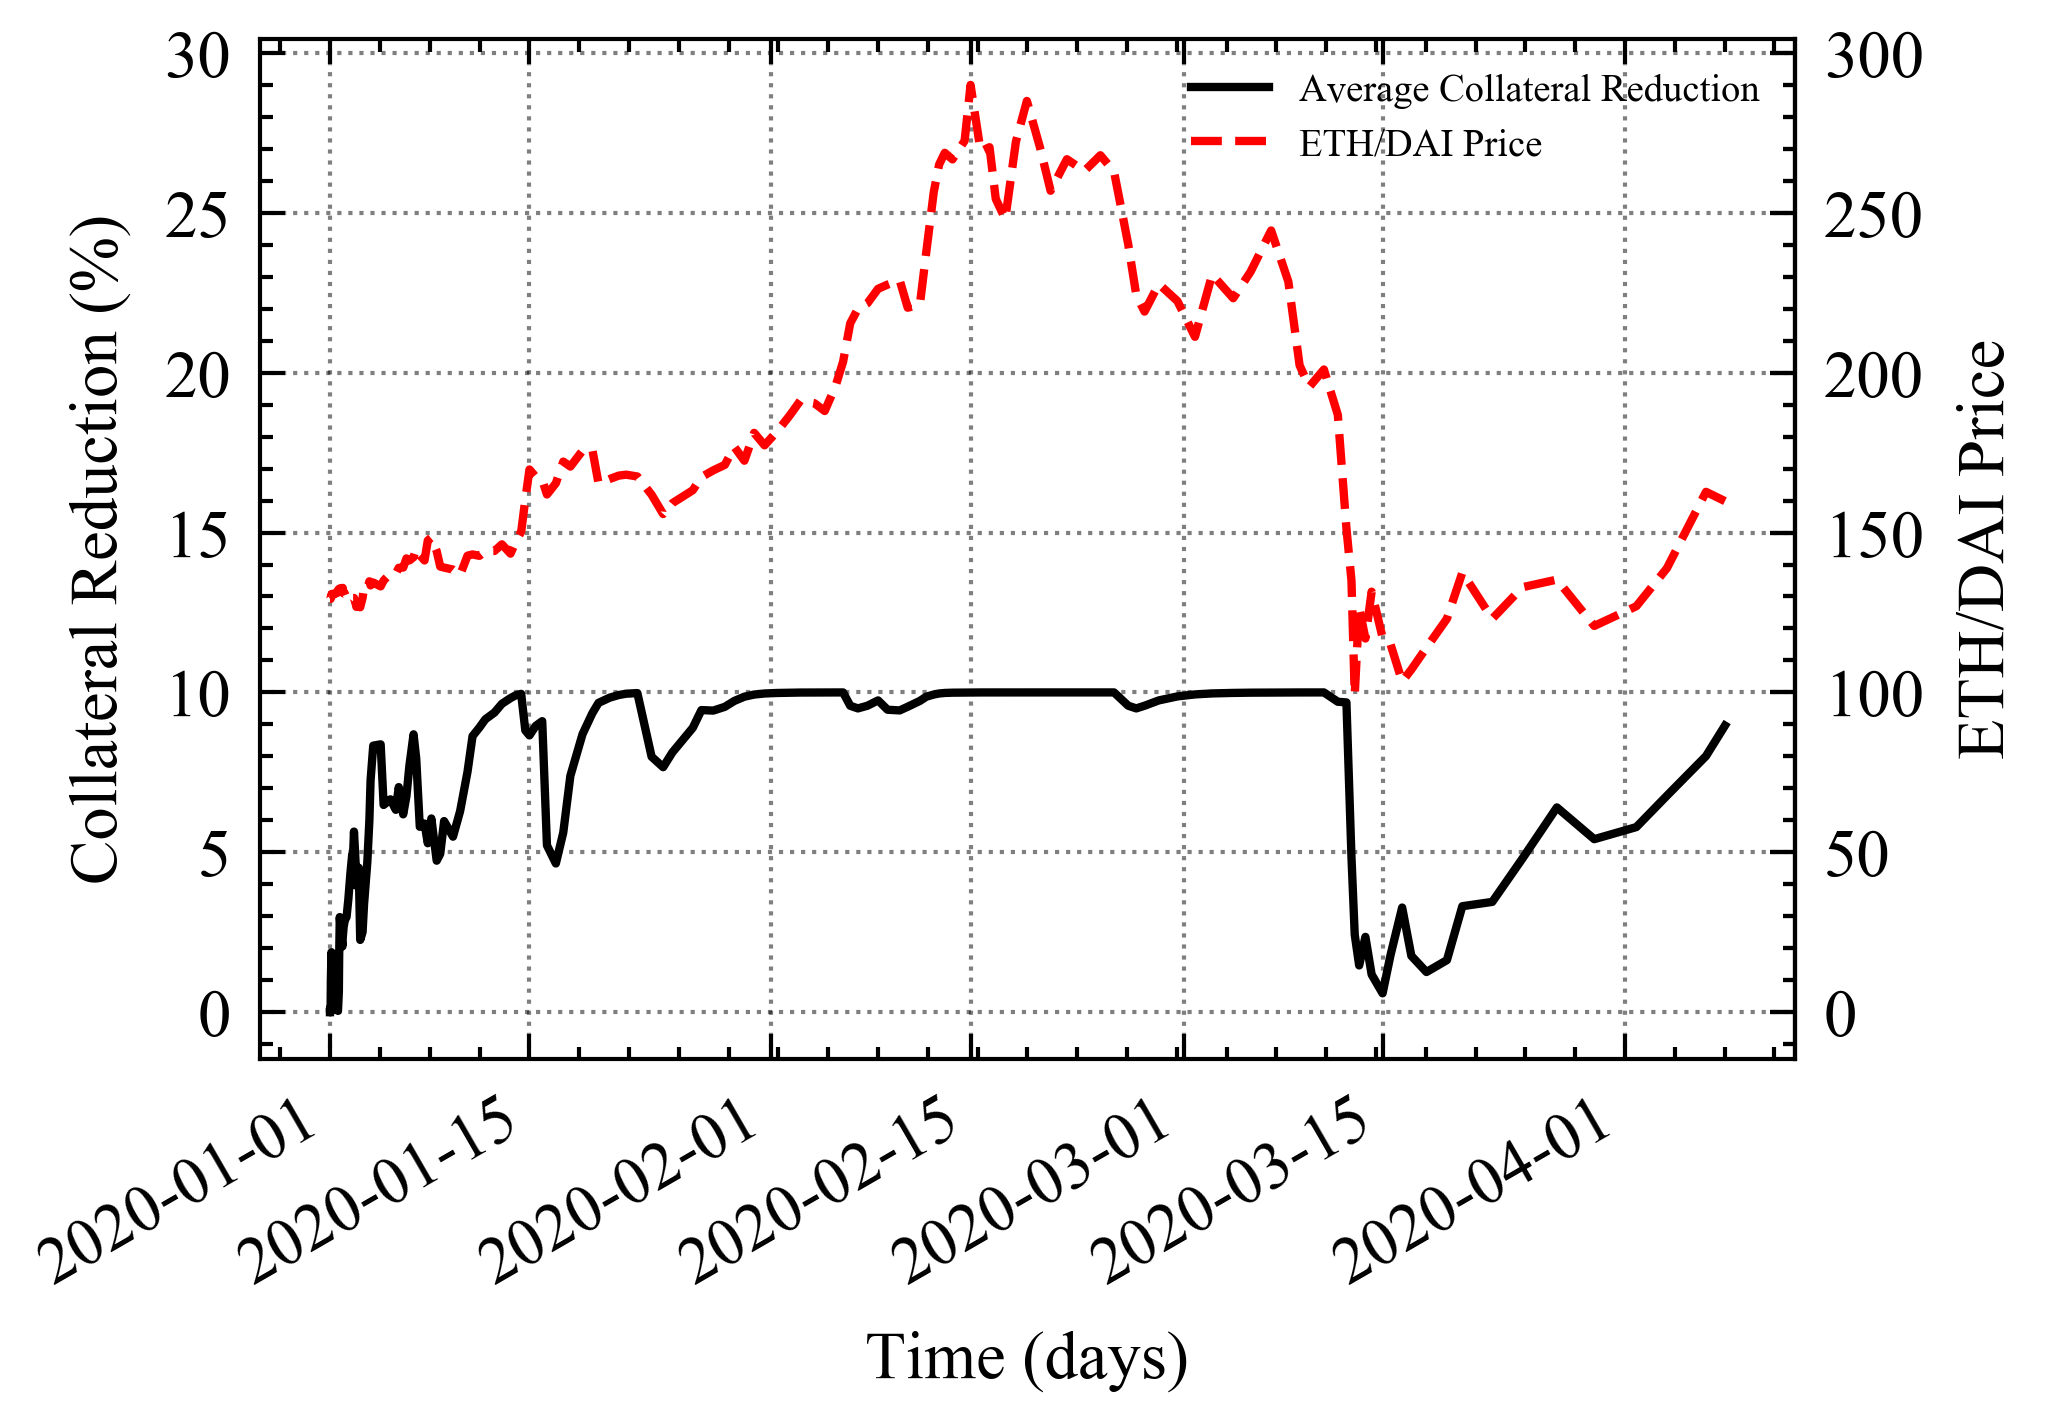

<Figure size 2100x1575 with 0 Axes>

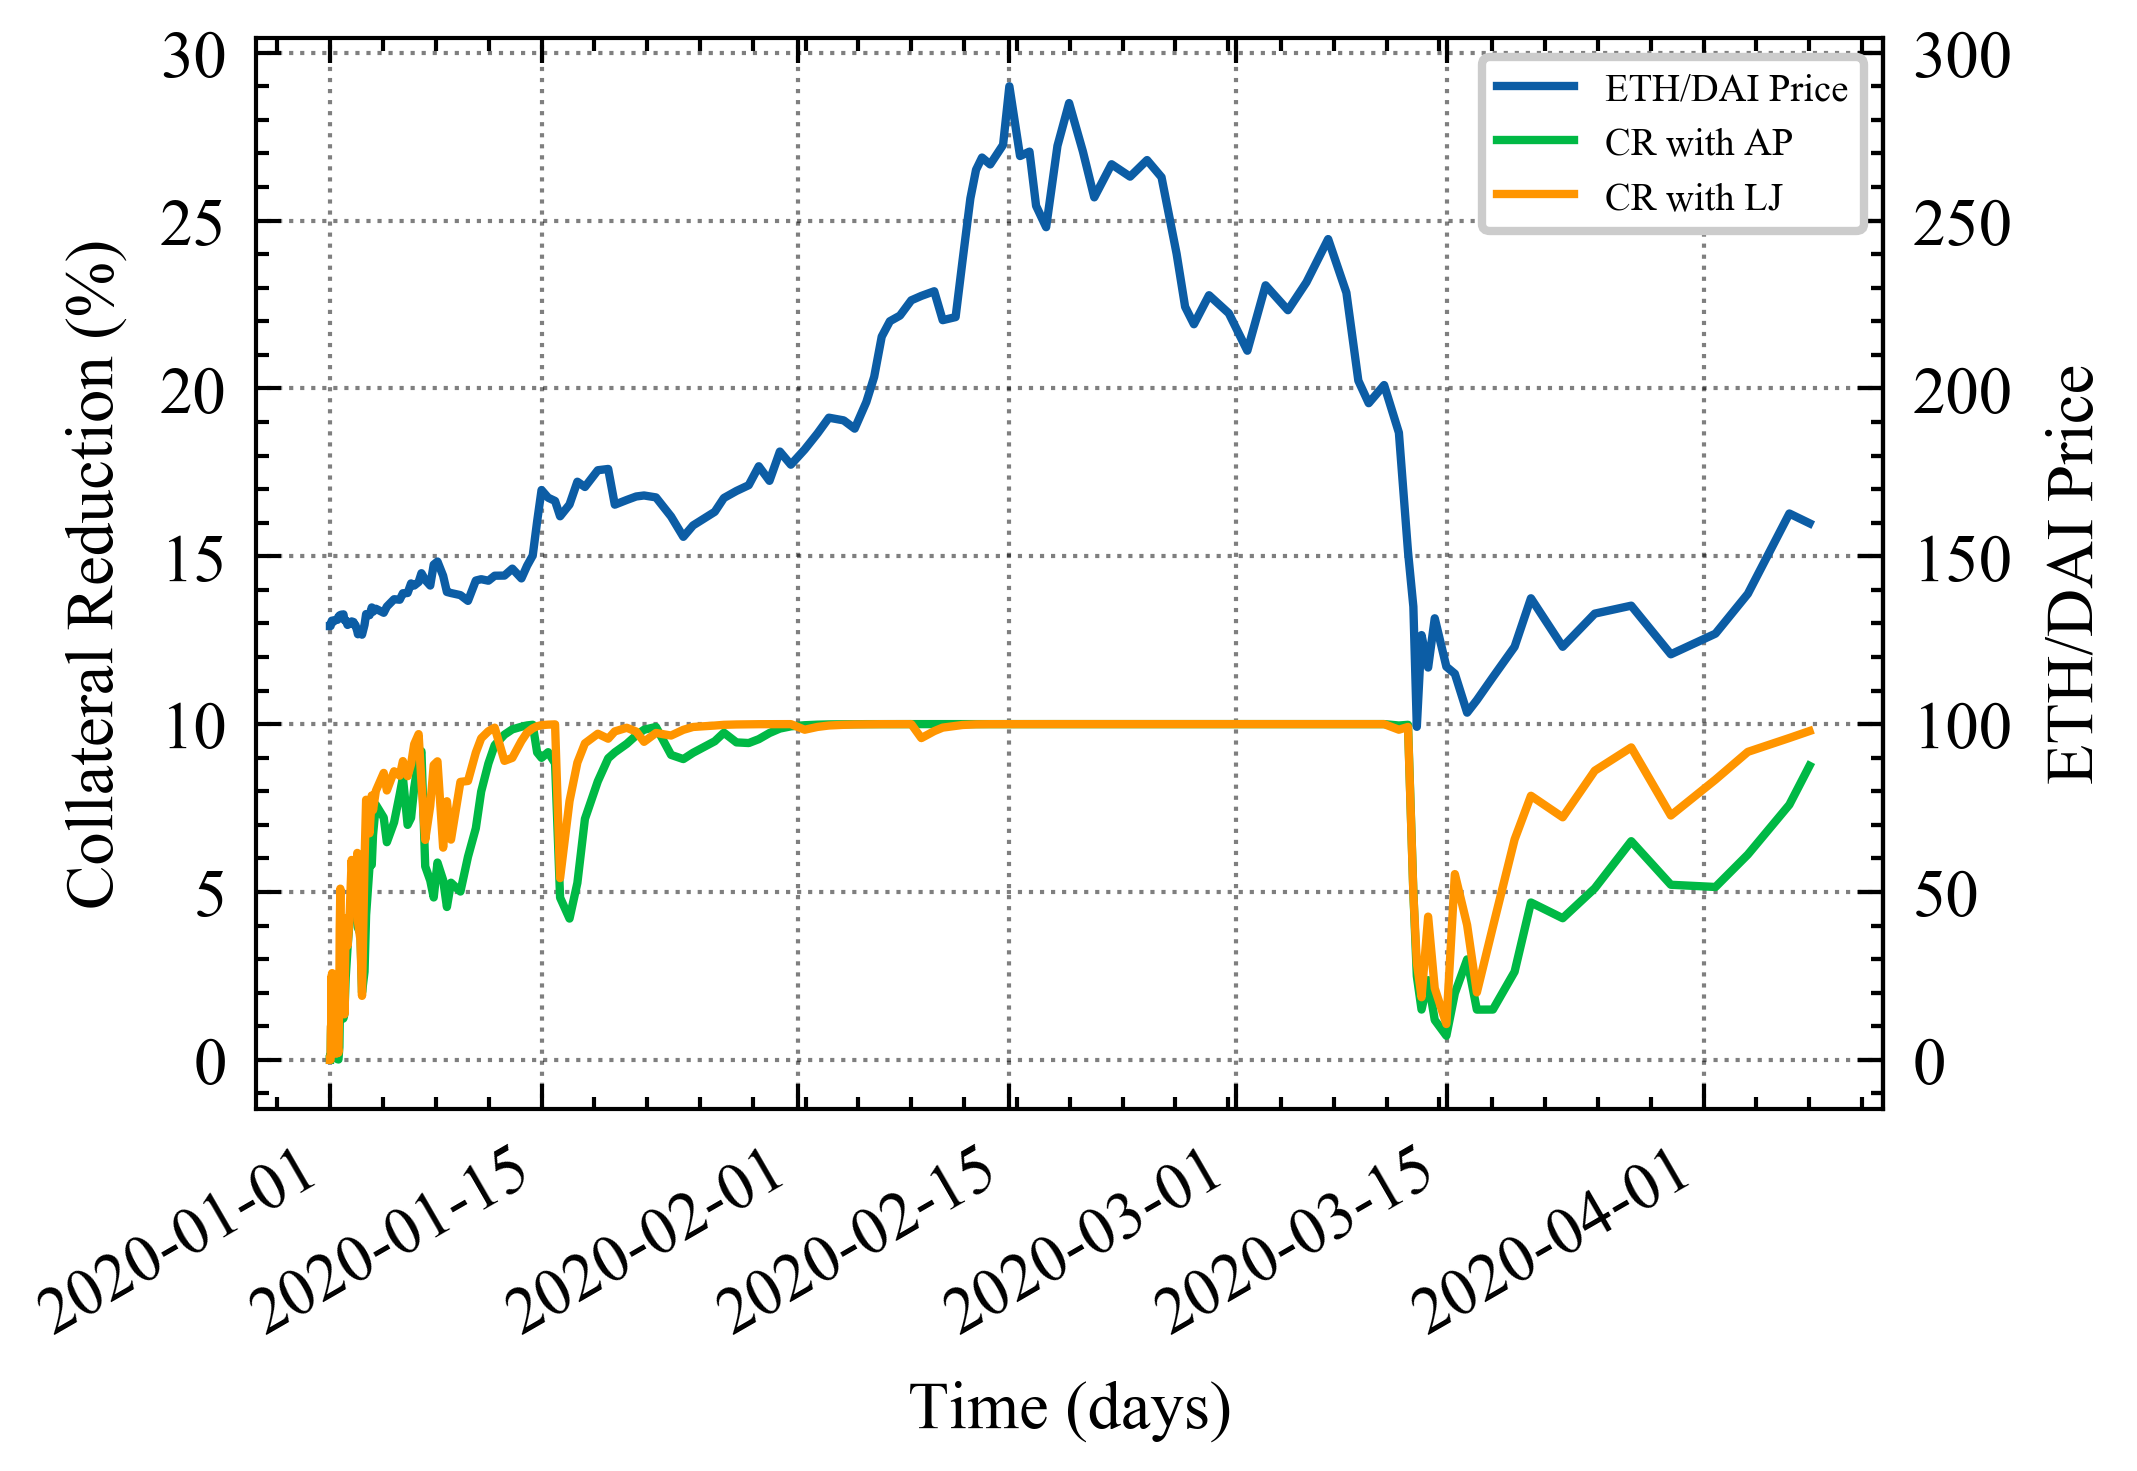

In [259]:
compoundUserCount = 100
# mint (deposit): 0xa0712d68 (cToken), 0x1249c58b (cETH)
# borrow (cETH, cToken): 0xc5ebeaec
# repay: 0x2608f818 (repayBorrowBehalf - cToken), 0x0e752702 (repayBorrow)
# liquidate: 0xf5e3c462

compoundRewards = {
    # mint
    "0xa0712d68": 2,
    "0x1249c58b": 2,
    
    # borrow
    "0xc5ebeaec": 25,
    
    # repay
    "0x2608f818": -15,
    "0x0e752702": -15,
    
    # liquidate
    "0xf5e3c462": -20
}

layerCount = 5
layerScores = [0, 10, 20, 29, 37]
layerDiscounts = [0, 0.03, 0.06, 0.09, 0.1]
interactionFrequencyProbabilities = [0.926985613, 0.040769679, 0.01473915, 0.007664359, 0.00431337, 0.00256803, 0.001569809, 0.000916284, 0.000473707]

layerCurationInterval = 6000


compoundSimulator = LbcrSimulator(compoundTxs, compoundUserCount, compoundRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities)
compoundSimulator.simulate()
compoundSimulator.computeSimulationStatistics()
compoundSimulator.displaySimulationResults()
# discounts = compoundSimulator.userLayerDiscountsPerPercentileOverTime[0]

# compoundSimulatorWithoutAsymmetricPromotion = LbcrSimulator(compoundTxs, compoundUserCount, compoundRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities, useAsymmetricLayerPromotion = False)
# compoundSimulatorWithoutAsymmetricPromotion.simulate()
# compoundSimulatorWithoutAsymmetricPromotion.computeSimulationStatistics()
# discountsWithAsymmetricPromotion = compoundSimulatorWithoutAsymmetricPromotion.userLayerDiscountsPerPercentileOverTime[0]

displaySimulationResults(compoundSimulator.curationDates, compoundSimulator.pricesAtCuration, discounts, 'CR with AP', discountsWithAsymmetricPromotion, 'CR with LJ', compoundSimulator.priceFeedScaleFactor)



46.933823529411775
0.29387254901960785


<Figure size 1980x1500 with 0 Axes>

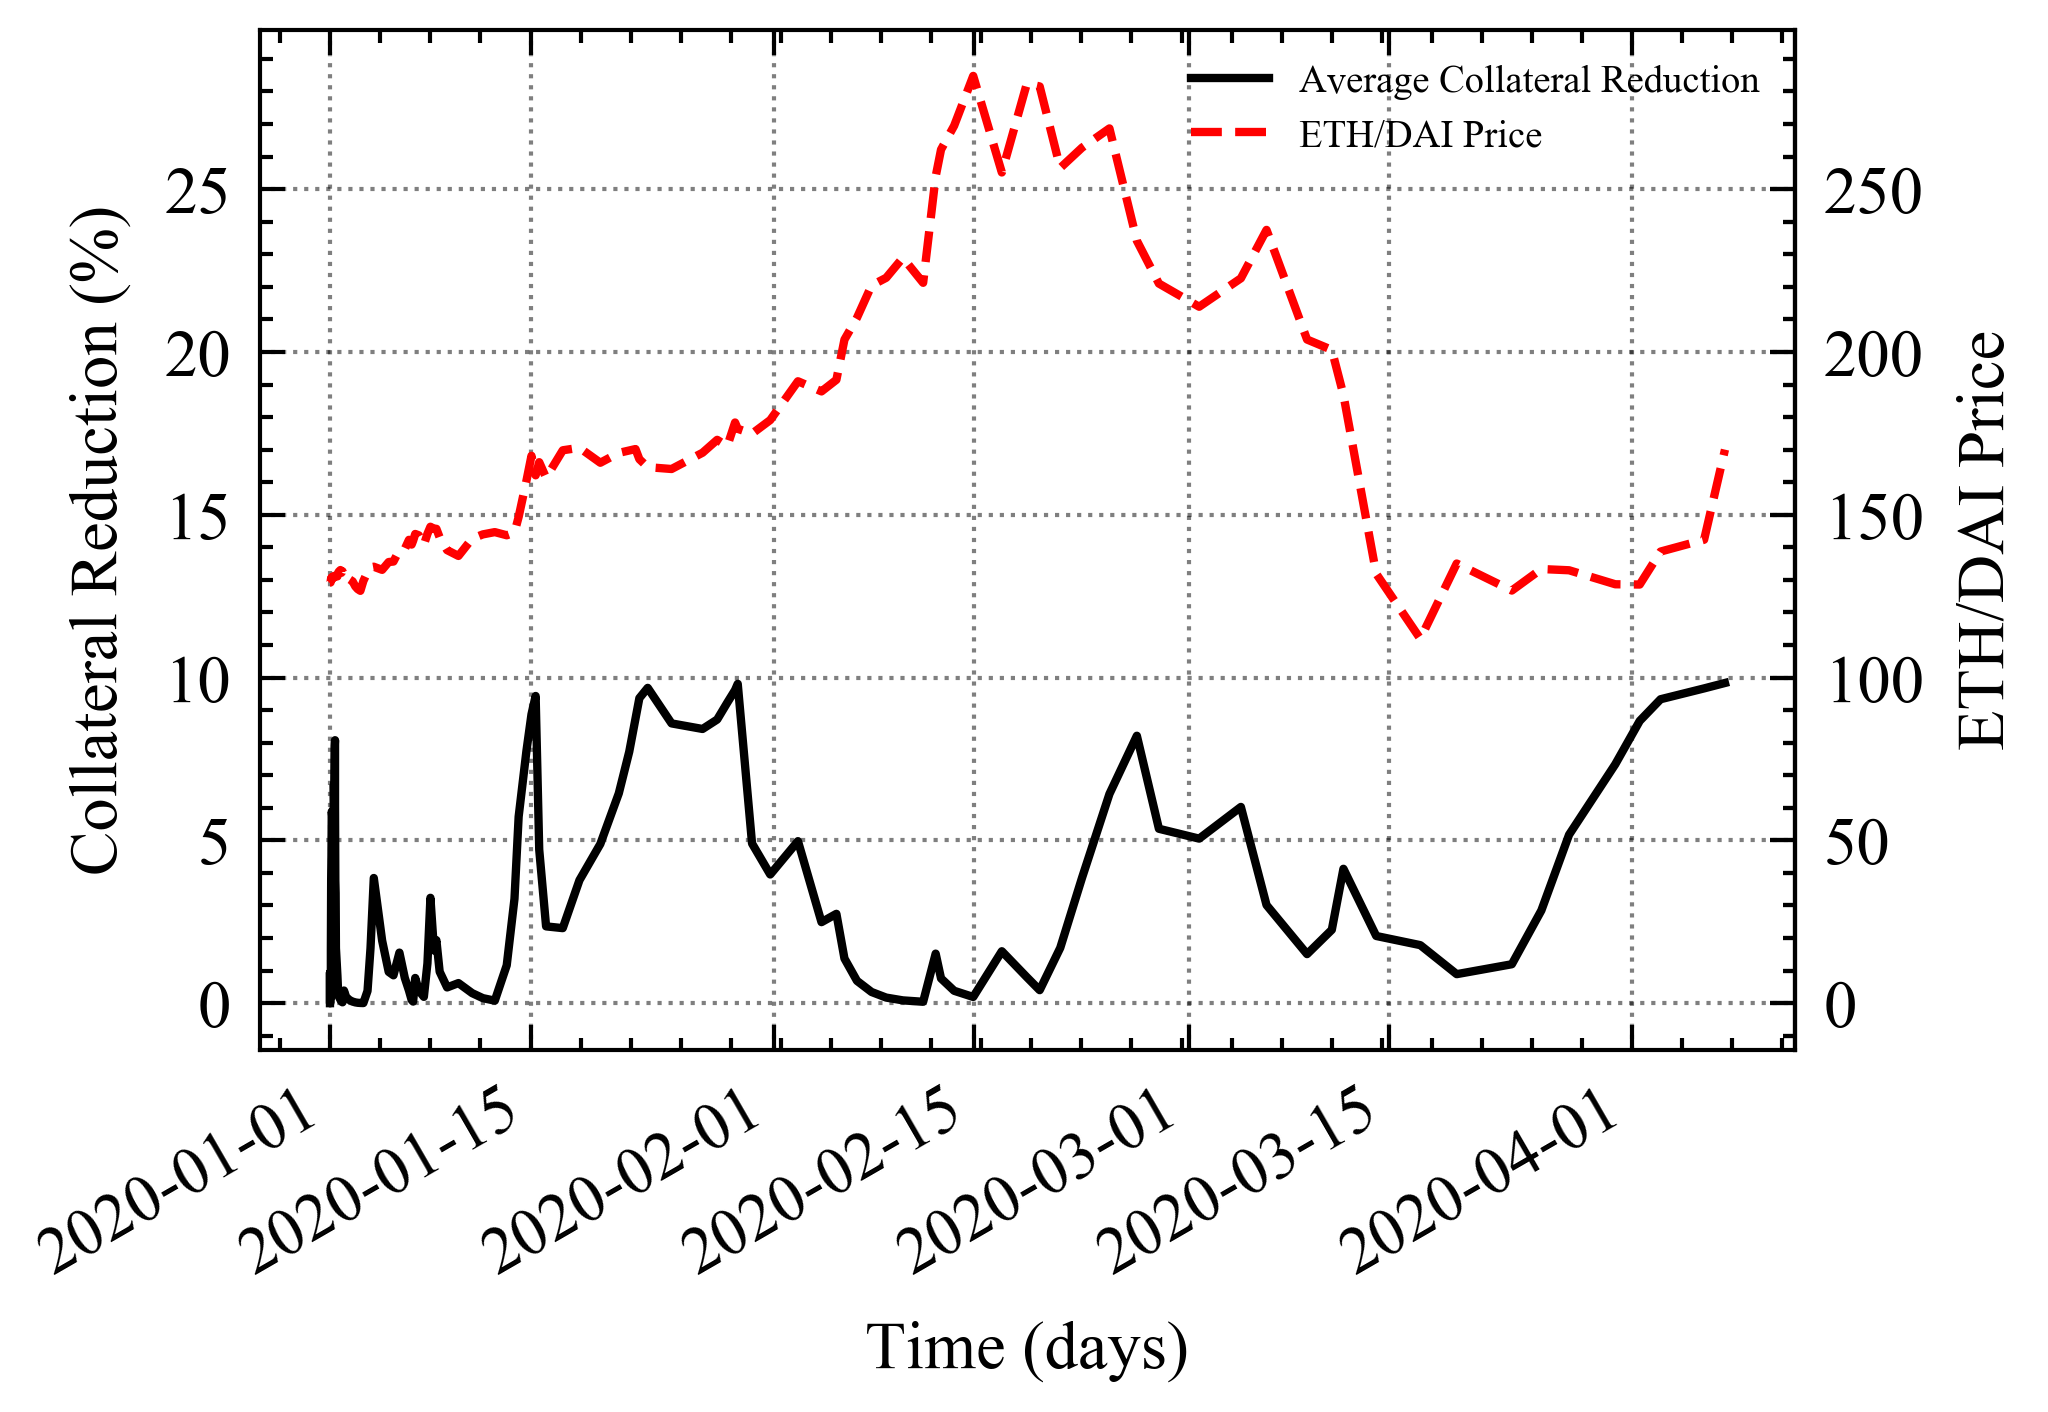

In [232]:
synthetixUserCount = 30
# issue (borrow): 0xaf086c7e (issueMaxSynths), 0x8a290014 (issueSynths)
# burn (repay): 0x295da87d (burnSynths)

synthetixRewards = {
    # issue
    "0xaf086c7e": 20,
    "0x8a290014": 20,
    
    # burn
    "0x295da87d": -15
}

layerCount = 5
layerScores = [0, 10, 20, 29, 37]
layerDiscounts = [0, 0.03, 0.06, 0.09, 0.1]
interactionFrequencyProbabilities = [0.971451785, 0.020495942, 0.003576747, 0.001774425, 0.001099053, 0.000722637, 0.000460777, 0.000283562, 0.000135073]

layerCurationInterval = 7000

synthetixSimulator = LbcrSimulator(synthetixTxs, synthetixUserCount, synthetixRewards, ethDaiPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval, interactionFrequencyProbabilities)
synthetixSimulator.simulate()
synthetixSimulator.computeSimulationStatistics()
synthetixSimulator.displaySimulationResults()


In [ ]:
makerUserCount = 50
# join (mint/borrow): 0x3b4da69f
# exit (burn/repay): 0xef693bed

makerRewards = {
    # issue
    "0xaf086c7e": 20,
    
    # burn
    "0xef693bed": -15
}

layerCount = 5
layerScores = [0, 10, 20, 29, 37]
layerDiscounts = [0, 0.033, 0.066, 0.1, 0.133]

layerCurationInterval = 3900

makerSimulator = LbcrSimulator(makerTxs, makerUserCount, makerRewards, ethUSDPriceCSV, layerCount, layerScores, layerDiscounts, layerCurationInterval)
makerSimulator.simulate()
makerSimulator.computeSimulationStatistics()
makerSimulator.displaySimulationResults()



In [322]:

def computeAggregation(p1Simulator, p2Simulator, p3Simulator, p1CompatibilityScore, p2CompatibilityScore, p3CompatibilityScore, label):
    byzanticAggregatedDiscountsForp1 = []

    p1CurationDateIndex = 0
    p2CurationDateIndex = 0
    p3CurationDateIndex = 0

    latestProtocolStartDate = max(
        p1Simulator.curationDates[0],
        p2Simulator.curationDates[0],
        p3Simulator.curationDates[0]
    )

    while p1CurationDateIndex < len(p1Simulator.curationDates) and p1Simulator.curationDates[p1CurationDateIndex] < latestProtocolStartDate:
        p1CurationDateIndex += 1

    while p2CurationDateIndex < len(p2Simulator.curationDates) and p2Simulator.curationDates[p2CurationDateIndex] < latestProtocolStartDate:
        p2CurationDateIndex += 1

    while p3CurationDateIndex < len(p3Simulator.curationDates) and p3Simulator.curationDates[p3CurationDateIndex] < latestProtocolStartDate:
        p3CurationDateIndex += 1

    aggregatedCurationDates = []
    pricesAtCuration = []
    p1Discounts = []

    while p1CurationDateIndex < len(p1Simulator.curationDates):
        p1CurationDate = p1Simulator.curationDates[p1CurationDateIndex]

        while p2CurationDateIndex < len(p2Simulator.curationDates) and p2Simulator.curationDates[p2CurationDateIndex] < p1CurationDate:
            p2CurationDateIndex += 1
        while p3CurationDateIndex < len(p3Simulator.curationDates) and p3Simulator.curationDates[p3CurationDateIndex] < p1CurationDate:
            p3CurationDateIndex += 1

        if p2CurationDateIndex == len(p2Simulator.curationDates) or p3CurationDateIndex == len(p3Simulator.curationDates):
            break
    #     print(p1CurationDate, p2Simulator.curationDates[p2CurationDateIndex], p3Simulator.curationDates[p3CurationDateIndex])

        avgProtocolDiscounts = [
            (p1CompatibilityScore, p1Simulator.userLayerDiscountsPerPercentileOverTime[0][p1CurationDateIndex]), 
            (p2CompatibilityScore, p2Simulator.userLayerDiscountsPerPercentileOverTime[0][p2CurationDateIndex]), 
            (p3CompatibilityScore, p3Simulator.userLayerDiscountsPerPercentileOverTime[0][p3CurationDateIndex])
        ]

        avgProtocolDiscounts.sort(key = lambda x: x[1], reverse=True)

        aggregatedDiscountInCurrentRound = 0
        compatibilityScoreRemaining = 1
        for (compatibilityScore, discount) in avgProtocolDiscounts:
#             aggregatedDiscountInCurrentRound += (compatibilityScore * discount)
            if compatibilityScoreRemaining == 0:
                break
            compatibilityScoreUsed = min(compatibilityScoreRemaining, compatibilityScore)
            compatibilityScoreRemaining -= compatibilityScoreUsed
            aggregatedDiscountInCurrentRound += (compatibilityScoreUsed * discount)

        byzanticAggregatedDiscountsForp1.append(aggregatedDiscountInCurrentRound)
        aggregatedCurationDates.append(p1CurationDate)
        pricesAtCuration.append(p1Simulator.pricesAtCuration[p1CurationDateIndex])
        p1Discounts.append(p1Simulator.userLayerDiscountsPerPercentileOverTime[0][p1CurationDateIndex])

        p1CurationDateIndex += 1


#     displaySimulationResults(aggregatedCurationDates, pricesAtCuration, p1Discounts, 'CR in ' + label, byzanticAggregatedDiscountsForp1, 'Aggregated CR for ' + label, p1Simulator.priceFeedScaleFactor)

    return (pricesAtCuration, byzanticAggregatedDiscountsForp1, aggregatedCurationDates)
    
p1CompatibilityScore = 1
p2CompatibilityScore = 0.4
p3CompatibilityScore = 0.3

# computeAggregation(synthetixSimulator, aaveSimulator, compoundSimulator, p1CompatibilityScore, p2CompatibilityScore, p3CompatibilityScore, "SNX")
# computeAggregation(aaveSimulator, synthetixSimulator, compoundSimulator, p1CompatibilityScore, p2CompatibilityScore, p3CompatibilityScore, "Aave")
(pricesAtCuration, discounts, aggregatedCurationDates) = computeAggregation(compoundSimulator, synthetixSimulator, aaveSimulator, p1CompatibilityScore, p2CompatibilityScore, p3CompatibilityScore, "Compound")




[110.44635461449077, 118.16372059650888, 133.4661644990178, 138.04439152858353, 134.33529662937414, 145.00822602301065, 179.0258247029813, 211.4584011501822, 295.1249327314981, 232.7866482629918, 250.69200273349873, 224.86472300119254, 253.14674026342544, 256.18843534718405, 280.6143993082205, 274.3944262613243, 258.90639425108384, 237.55684632540044, 210.0471816458413, 232.8082034165255]


<Figure size 2100x1575 with 0 Axes>

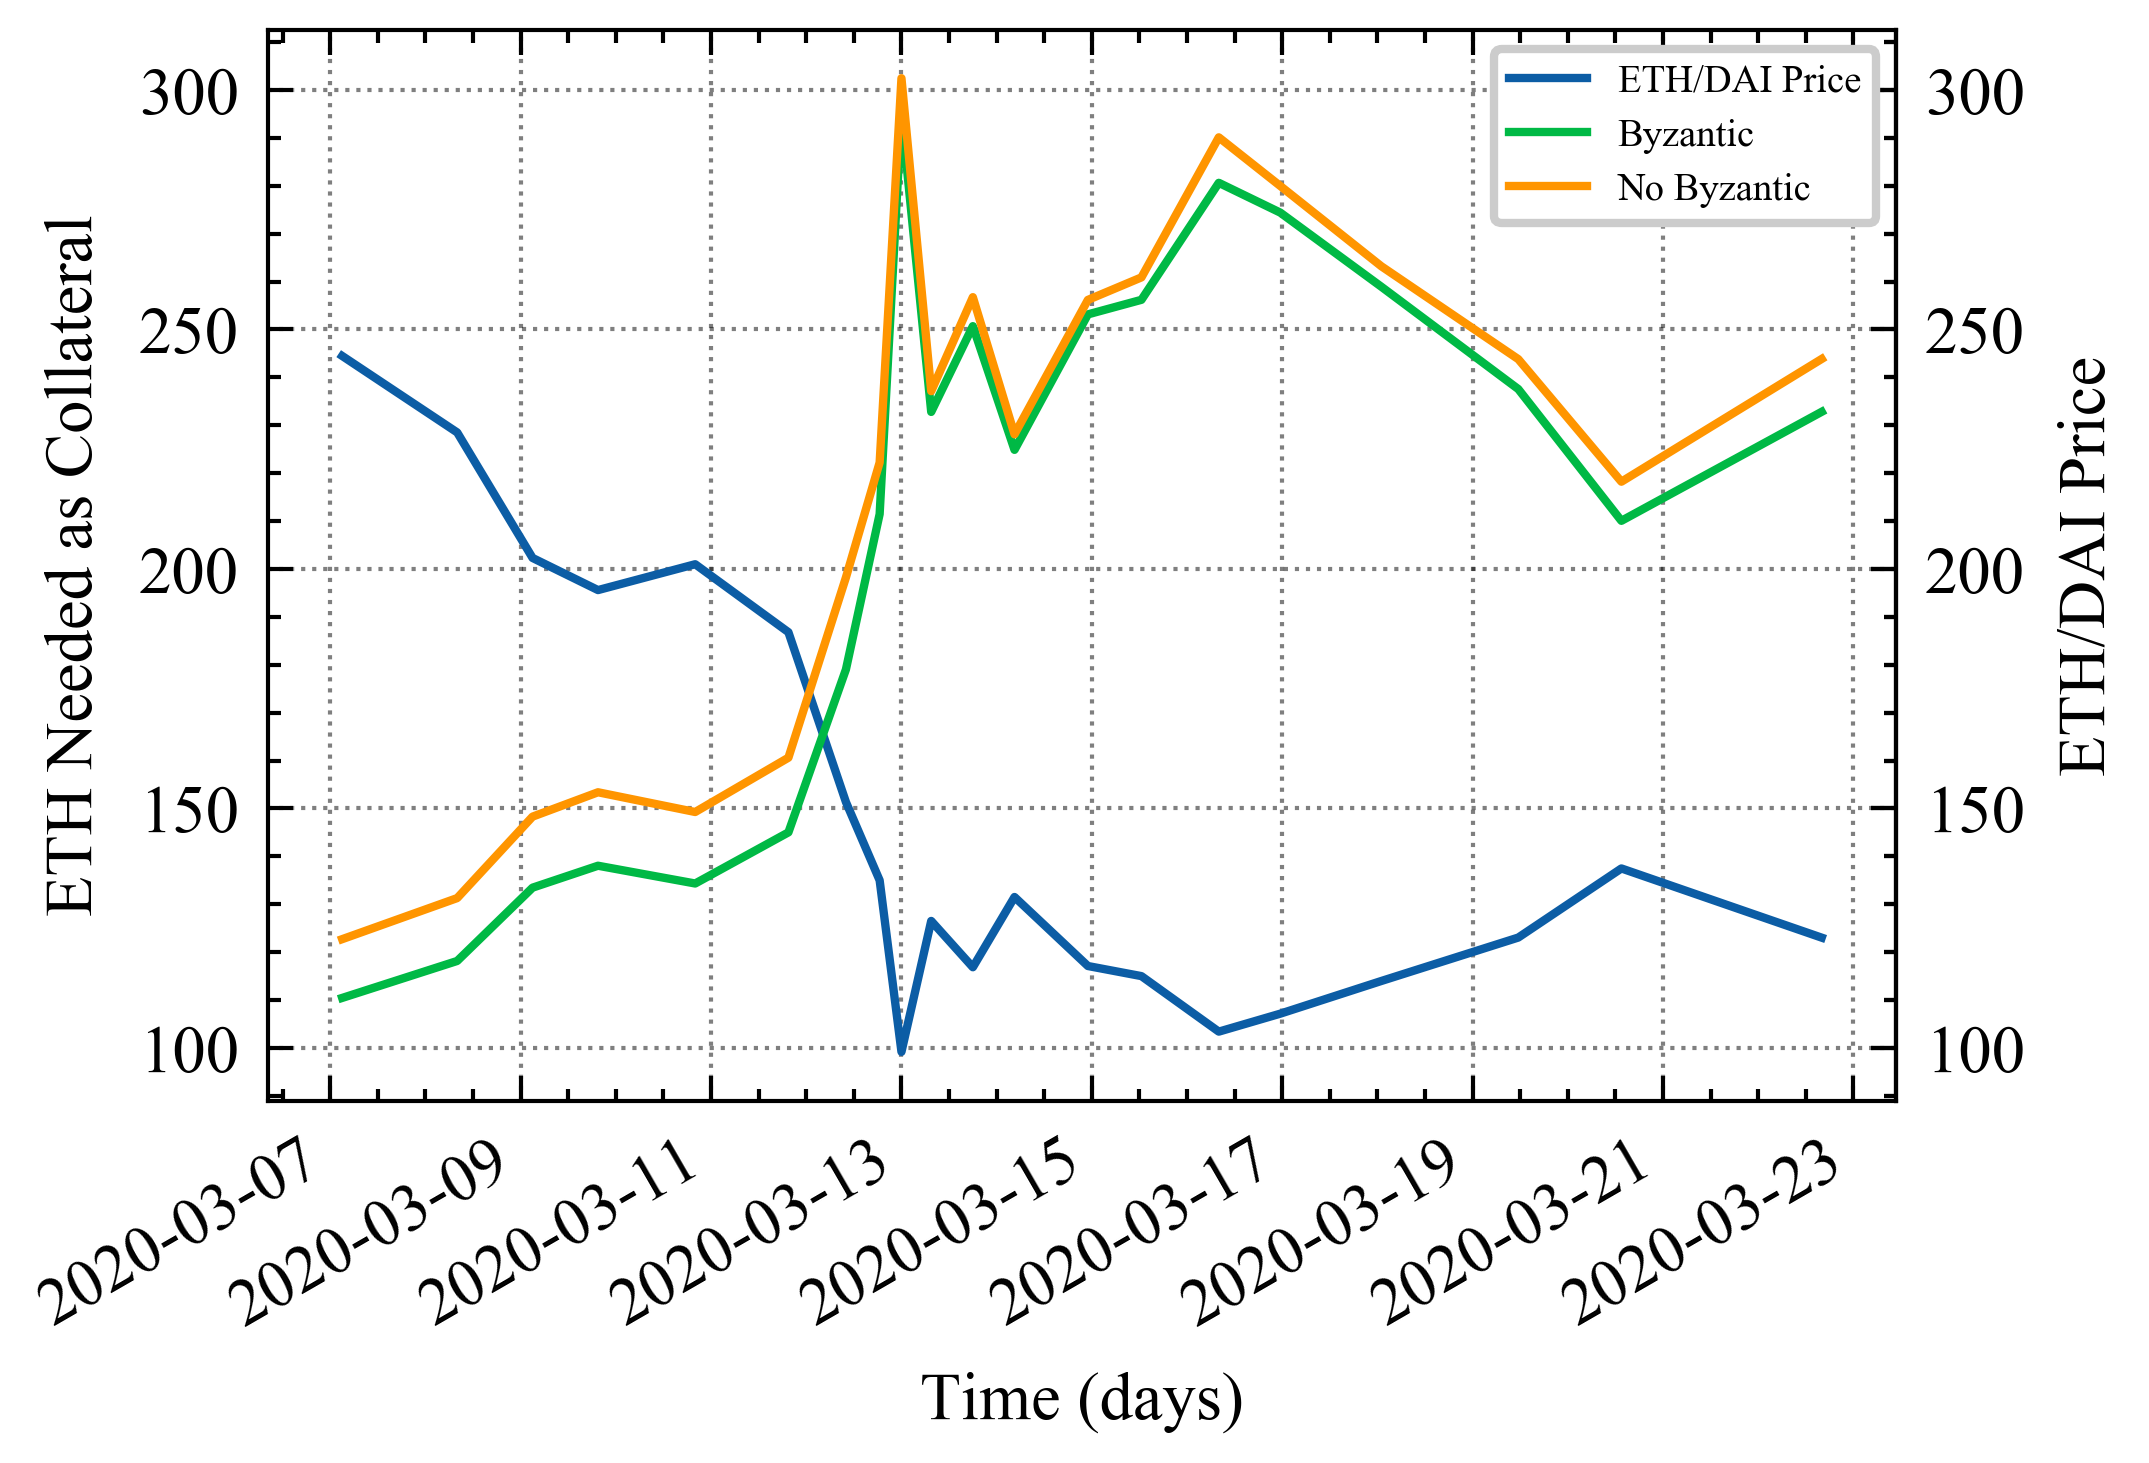

In [347]:
# print(len(aggregatedCurationDates))
# print(len(discounts))
startSlice = 82
endSlice = -5
crisisDiscounts = discounts[startSlice:endSlice]
crisisDates = aggregatedCurationDates[startSlice:endSlice]

prices = [price * 10 for price in pricesAtCuration[startSlice:endSlice]]

overCollRates150 = [150 * (1 - discount) for discount in crisisDiscounts]
overCollRates300 = [300 * (1 - discount) for discount in crisisDiscounts]

collAmounts = []
noByzanticCollAmounts = []
for price, collRates in zip(prices, overCollRates150):
    collateralFor100Dai = 2 * collRates / price * 100    
    collAmounts.append(collateralFor100Dai)
    
    noByzanticCollateralFor100Dai = 2* 150 / price * 100
    noByzanticCollAmounts.append(noByzanticCollateralFor100Dai)
    
    

print(collAmounts)

# overCollRates500 = [500 * (1 - discount) for discount in crisisDiscounts]
# plt.gcf().autofmt_xdate()
# plt.plot(crisisDates, overCollRates150)
# plt.plot(crisisDates, overCollRates300)
# plt.plot(crisisDates, overCollRates500)


# rateAtLoanTime = crisisPrices[0]
# ethCollateralAmount = 150 / rateAtLoanTime
# print(ethCollateralAmount)
# # overCollRates = [ethCollateralAmount * price for price in crisisPrices]
# overCollRates = [150 - discount for discount in crisisDiscounts]

# 139 dai for one eth
# loan 100 dai using 150% collateral, i.e. 150/139 (150 / prices[0]) 1.079 eth. When eth falls to 100, the loans is only 108% collateralised


curationDatesArray = [
    crisisDates,
    crisisDates,
#     crisisDates,
#     crisisDates,
]

discountsArray = [
#     overCollRates150,
    collAmounts,
    noByzanticCollAmounts,
#     overCollRates300,
#     overCollRates500,
]

labelArray = [
    "Byzantic",
    "No Byzantic",
#     "300%",
#     "500%",
]

displayNSimulationResults(
    curationDatesArray,
    [price * 10 for price in pricesAtCuration[startSlice:endSlice]],
    1,
    discountsArray,
    labelArray,
    discountScale = 1,
    ylabel = "ETH Needed as Collateral"
)
